In [1]:
from PIL import Image as PILImage
from img2table.document import Image
from img2table.ocr import PaddleOCR, TesseractOCR
from img2table.tables.processing.common import get_contours_cell, is_contained_cell, merge_contours
from img2table.tables.processing.lines import detect_lines
from img2table.tables.processing.borderless_tables.prepare_image import prepare_image
from img2table.tables.objects.cell import Cell
from colordict import ColorDict
import cv2
import numpy as np

C:\Users\xavca\PycharmProjects\img2table\venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
C:\Users\xavca\PycharmProjects\img2table\venv\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [2]:
import random
colors = ColorDict()

def get_color():
    idx = random.randint(0, len(colors) - 1)
    return list(colors.values())[idx]

### Loading image

In [21]:
img = Image(r"C:\Users\xavca\Pictures\test_imgs\nbl.png")
ocr = TesseractOCR()
ocr_df = ocr.of(img)

img = prepare_image(list(img.images)[0])

### Word image

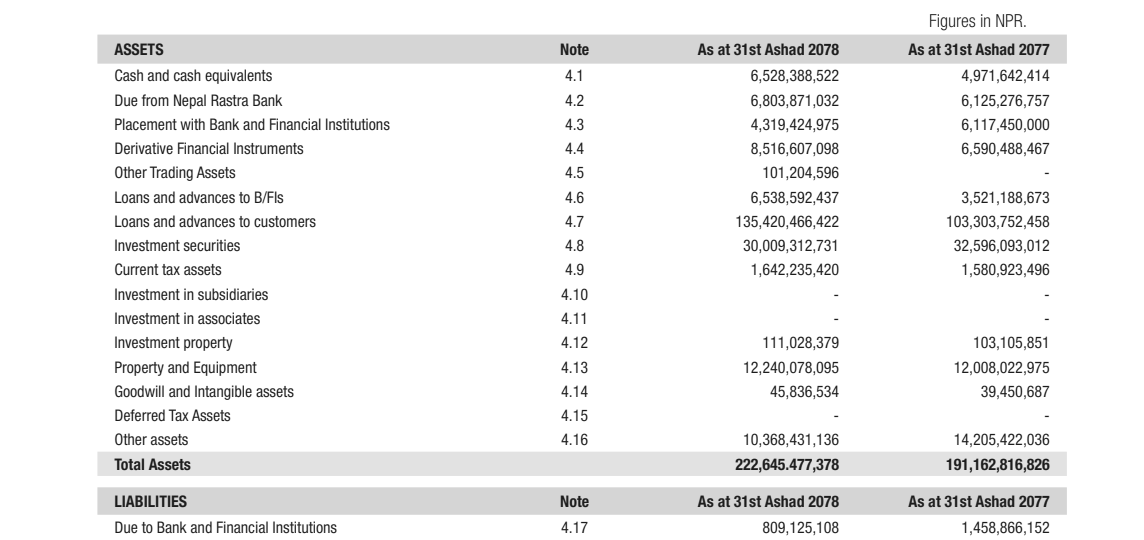

In [22]:
from img2table.tables.processing.tables.implicit_rows import create_word_image

word_image = create_word_image(img=img, ocr_df=ocr_df, min_confidence=20)

PILImage.fromarray(img)

### Text segmentation

In [23]:
from img2table.tables.processing.borderless_tables.segment_image import segment_image_text

img_segments = segment_image_text(img=img, ocr_df=ocr_df)

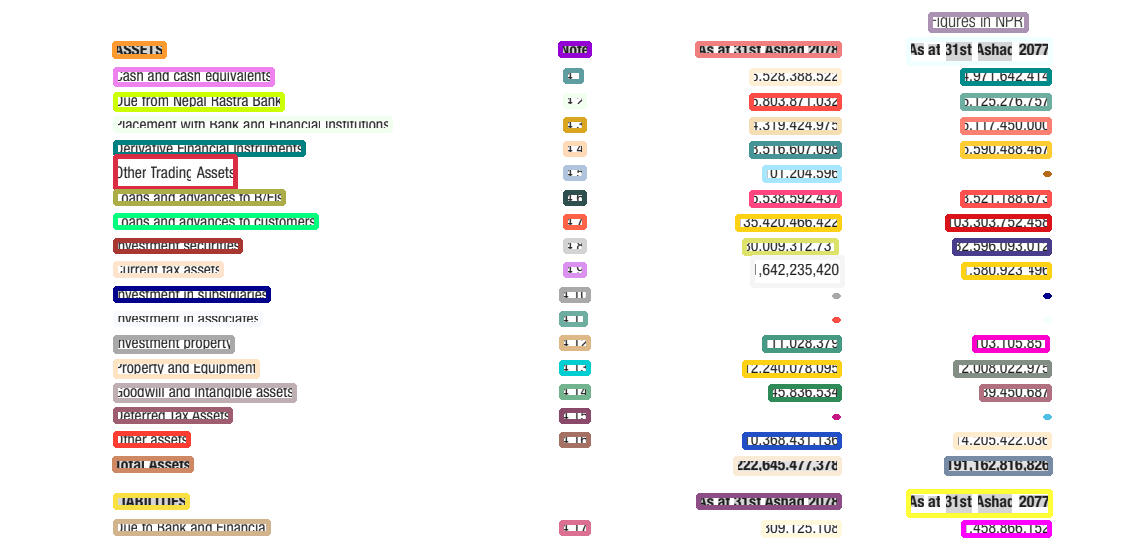

In [24]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for segment in img_segments:
    for cnt in segment:
        cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), get_color(), 3)
PILImage.fromarray(display_img)

In [25]:
import json

segment = img_segments[0]

with open("data/segment_cells.json", "w") as f:
    data = [{"x1": c.x1, "y1": c.y1, "x2": c.x2, "y2": c.y2} for c in segment]
    json.dump(data, f)

### Table detection

In [26]:
from img2table.tables.processing.borderless_tables.alignment import cluster_aligned_text
from img2table.tables.processing.borderless_tables.identify_tables import identify_tables
from img2table.tables.processing.borderless_tables.table_creation import create_table_from_clusters

list_tables = list()
alignment_cls = list()
table_cls = list()
for segment in img_segments:
    # Cluster text contours based on alignment
    alignment_clusters = cluster_aligned_text(segment=segment)
    alignment_cls += alignment_clusters

    # Table detection based on clusters
    table_clusters = identify_tables(clusters=alignment_clusters)
    table_cls += table_clusters

    # Create table objects
    for table_cluster in table_clusters:
        table = create_table_from_clusters(tb_clusters=table_cluster,
                                           segment_cells=[c for c in segment])

        if table:
            list_tables.append(table)

### Alignment

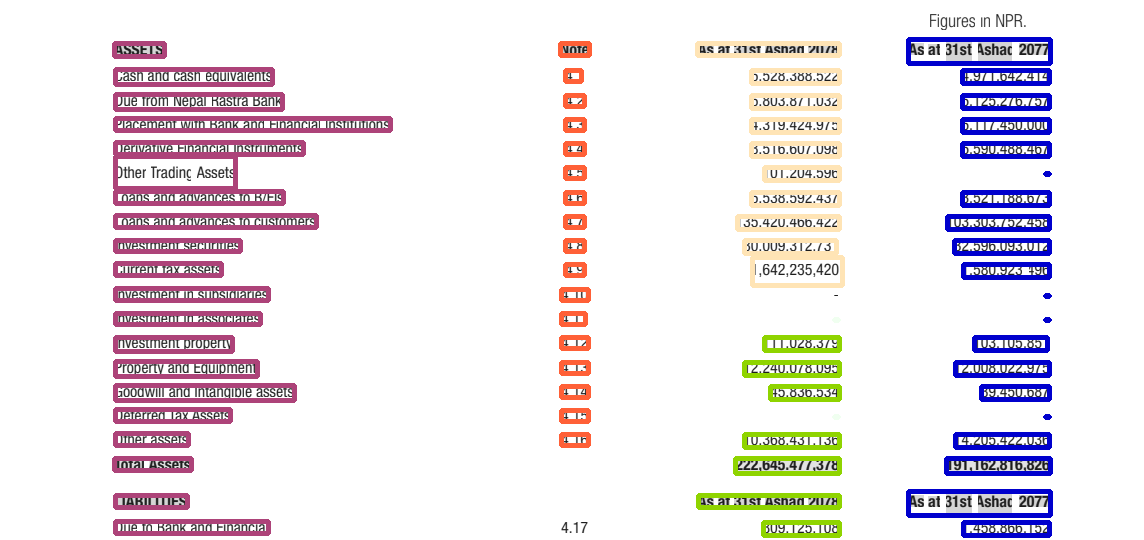

In [27]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for clust in alignment_cls:
    color = get_color()
    for cnt in clust:
        cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

### Clusters

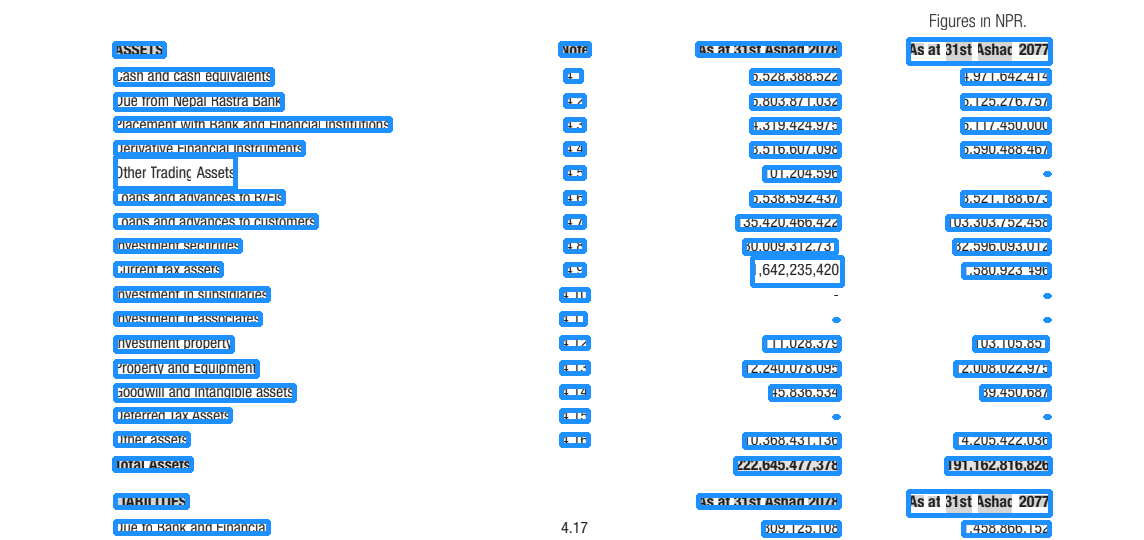

In [28]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for tb in table_cls:
    color = get_color()
    for clust in tb:
        for cnt in clust:
            cv2.rectangle(display_img, (cnt.x1, cnt.y1), (cnt.x2, cnt.y2), color, 3)

PILImage.fromarray(display_img)

### Tables

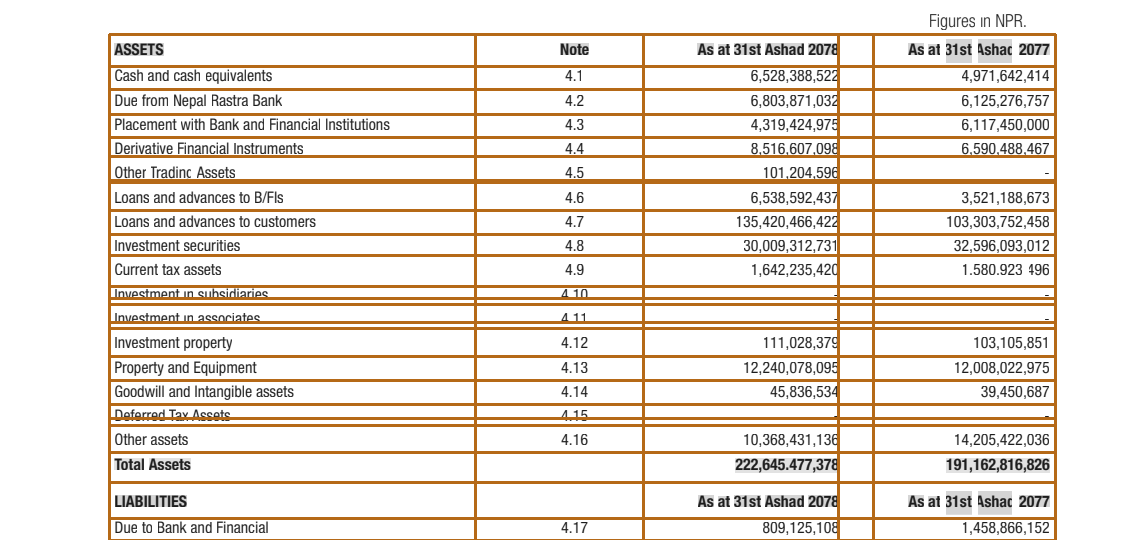

In [29]:
display_img = cv2.cvtColor(word_image.copy(), cv2.COLOR_GRAY2RGB)

for table in list_tables:
    color = get_color()
    for row in table.extracted_table.content.values():
        for cell in row:
            cv2.rectangle(display_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), color, 2)

PILImage.fromarray(display_img)